<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples,adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [6]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)




sample_df = train.groupby('label').apply(lambda x: x.sample(10000, random_state=99))
sample_df.index = sample_df.index.get_level_values(1)
sample_df.head()

sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])



In [7]:


def find_best_dbscan(X,eps_lst, min_samp_lst):
  best_model = None 
  m = {'eps' : [],
       'min_samp' : [],
      'cluster':[],
       'score':[],
       'homogenity': [],
       'completeness': [],
        'davies_bouldin':[]}
  

  fig, ax = plt.subplots(4,4, figsize=(20,20))
  fig.suptitle('DBScan Clustering')
  ax = ax.flatten()

  ax_idx = 0
  for eps in eps_lst:
    for min_sample in min_samp_lst:
      dbscan = DBSCAN(eps=eps, min_samples=min_sample,
                      n_jobs=-1)
      cls = dbscan.fit_predict(X_std)
      
      # following code provided by https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/
      clusters =dbscan.labels_
      num_clusters=len(set(clusters))-(1 if -1 in clusters else 0)
      
      
      
      score = silhouette_score(X_std,clusters,
                random_state=99)
      
      hg = homogeneity_score(sample_df.label, clusters)
      comp = completeness_score(sample_df.label, clusters)
      davies = davies_bouldin_score(X_std, clusters )

      m['eps'].append(eps)
      m['min_samp'].append(min_sample)
      

    
      m['cluster'].append(num_clusters)
      m['homogenity'].append(hg)
      m['completeness'].append(comp)
      m['davies_bouldin'].append(davies)


      scatter = ax[ax_idx].scatter(X_pca[:,0],X_pca[:,1], 
                                c=clusters,s=50, cmap='viridis')
      ax[ax_idx].set_title(f"k={num_clusters},eps={eps},min_samp={min_sample}")
      ax[ax_idx].set_xlabel("X0"); 
      ax[ax_idx].set_ylabel("X1")

      fig.colorbar(scatter, ax=ax[ax_idx])

      if best_model == None:
        best_model = dbscan
      elif score > np.max(m['score']):
        best_model = dbscan   
      m['score'].append(score)

      ax_idx += 1

    
  return m, best_model

In [8]:
lst_results = []

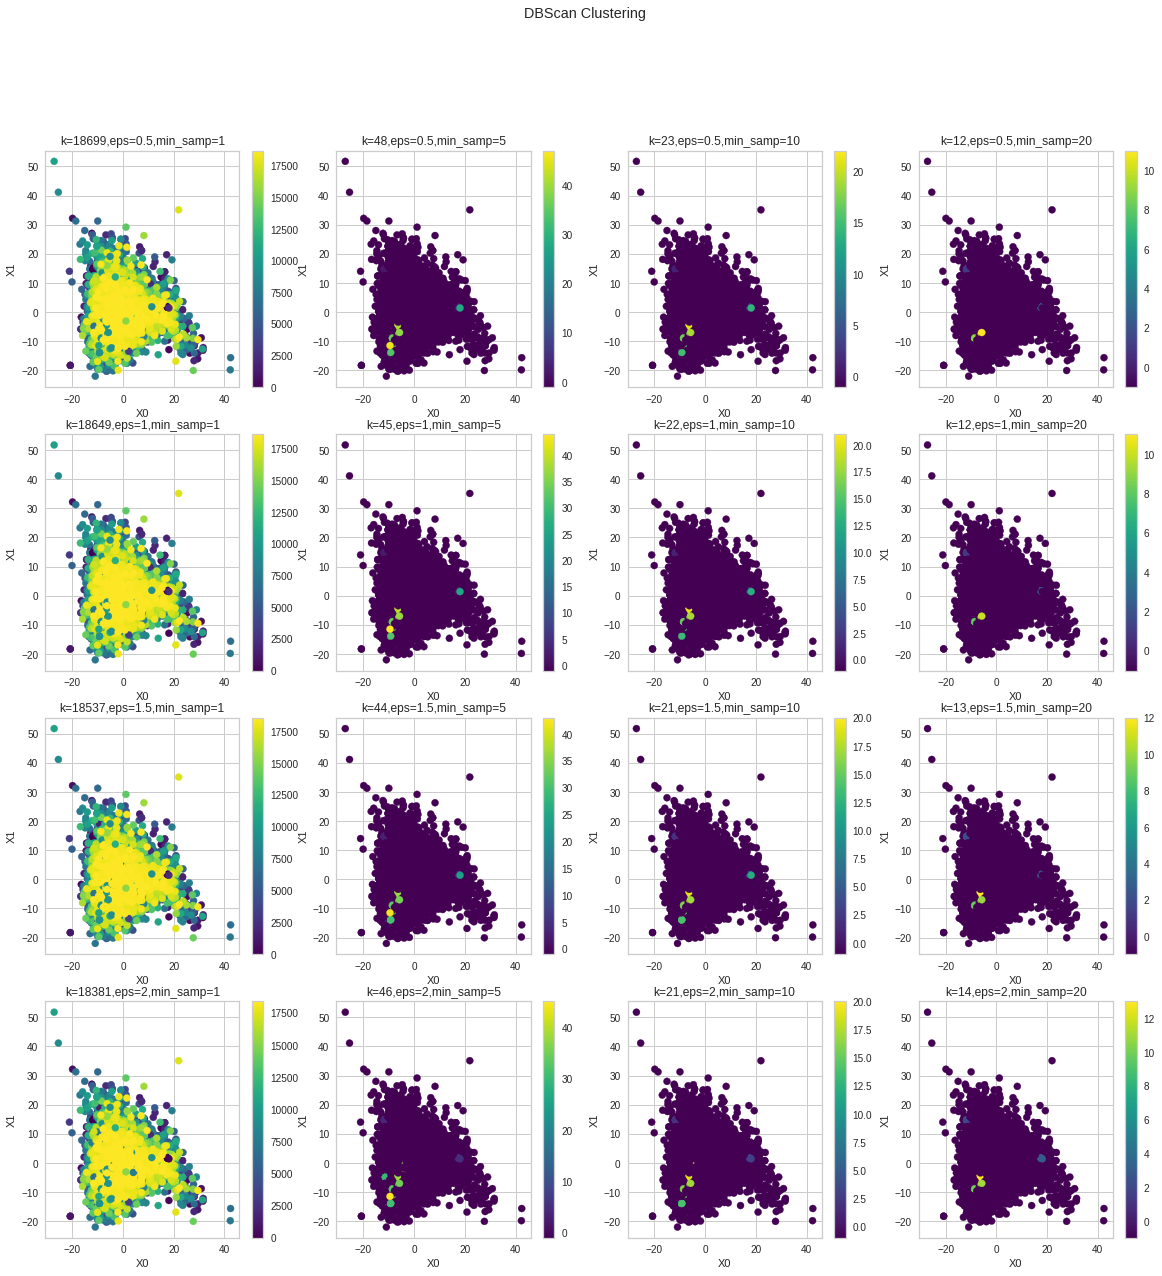

In [9]:
X_std = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_std)
results,db_scan_best_model = find_best_dbscan(X_std, [.5, 1, 1.5, 2], [1,5,10,20])


In [ ]:
results_df = pd.DataFrame(results)
lst_results.append(results_df)

In [ ]:
results_df.sort_values('score', ascending=False)

,eps,min_samp,cluster,score,homogenity,completeness,davies_bouldin
12,2.0,1,9350,0.079527,0.965546,0.073965,0.075140
8,1.5,1,9412,0.073599,0.973907,0.074488,0.051395
4,1.0,1,9472,0.071553,0.979631,0.074752,0.030852
0,0.5,1,9498,0.069554,0.982082,0.074881,0.014175
3,0.5,20,6,-0.102335,0.013296,0.083690,0.841823
7,1.0,20,7,-0.102938,0.015569,0.085498,0.869683
15,2.0,20,6,-0.141072,0.018957,0.090585,0.927166
11,1.5,20,6,-0.142260,0.018813,0.092259,0.923924
14,2.0,10,16,-0.155721,0.031247,0.090514,0.931539
10,1.5,10,15,-0.159113,0.029093,0.091212,0.922962


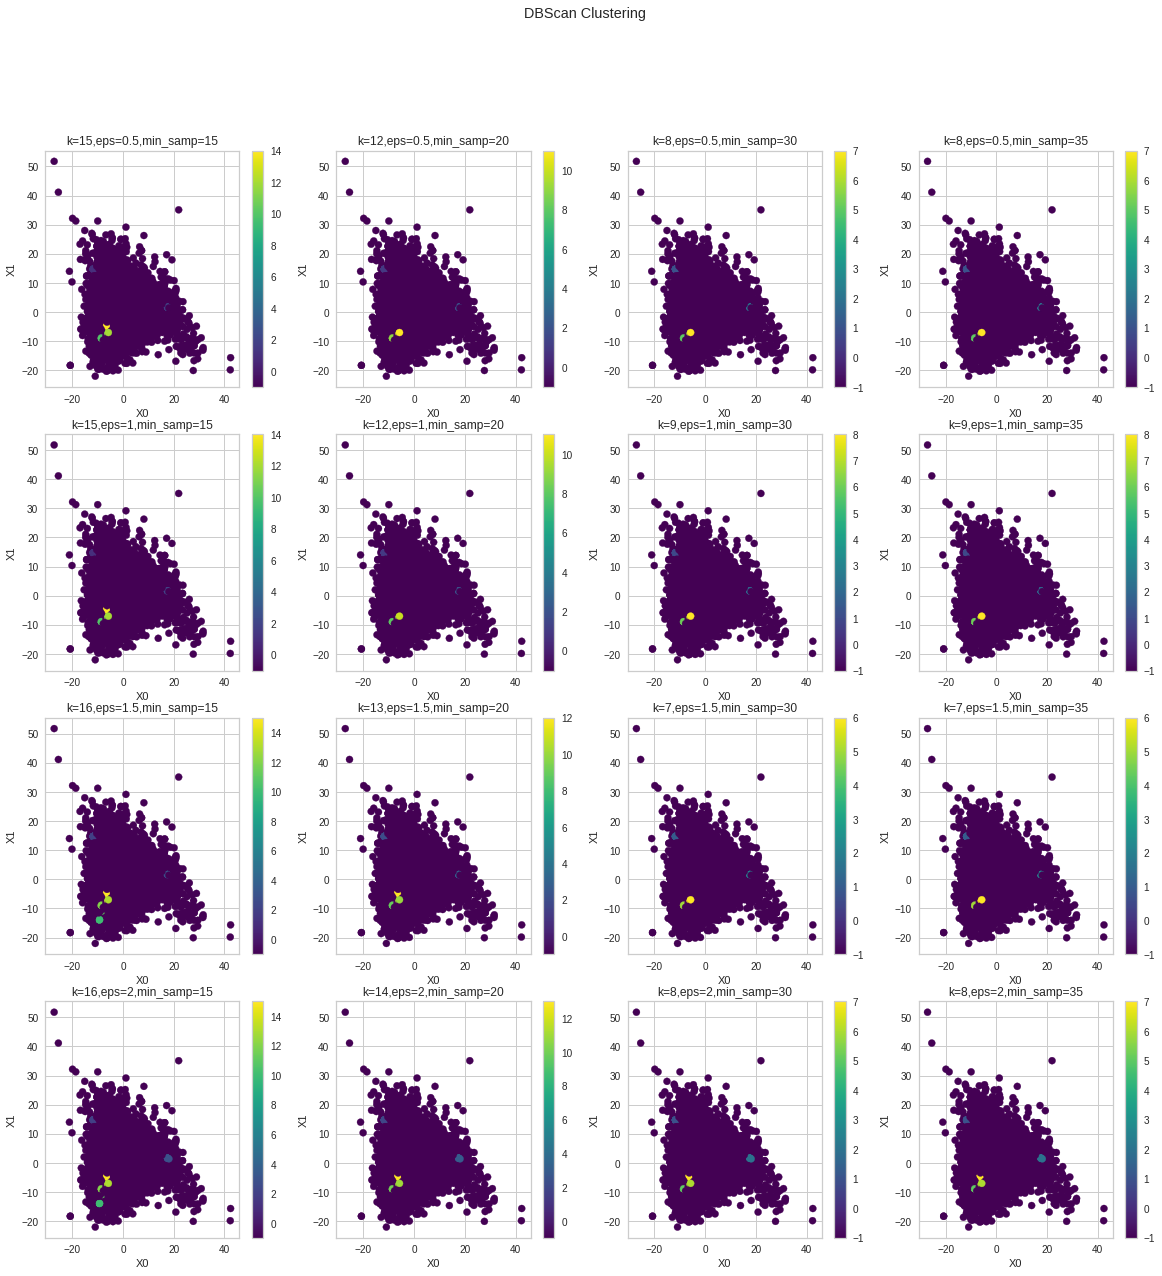

In [11]:
second_results,db_scan_snd_run_best_model = find_best_dbscan(X_std, [.5, 1, 1.5, 2], [15,20,30,35])

In [12]:
second_results_df = pd.DataFrame(second_results)
lst_results.append(second_results_df)

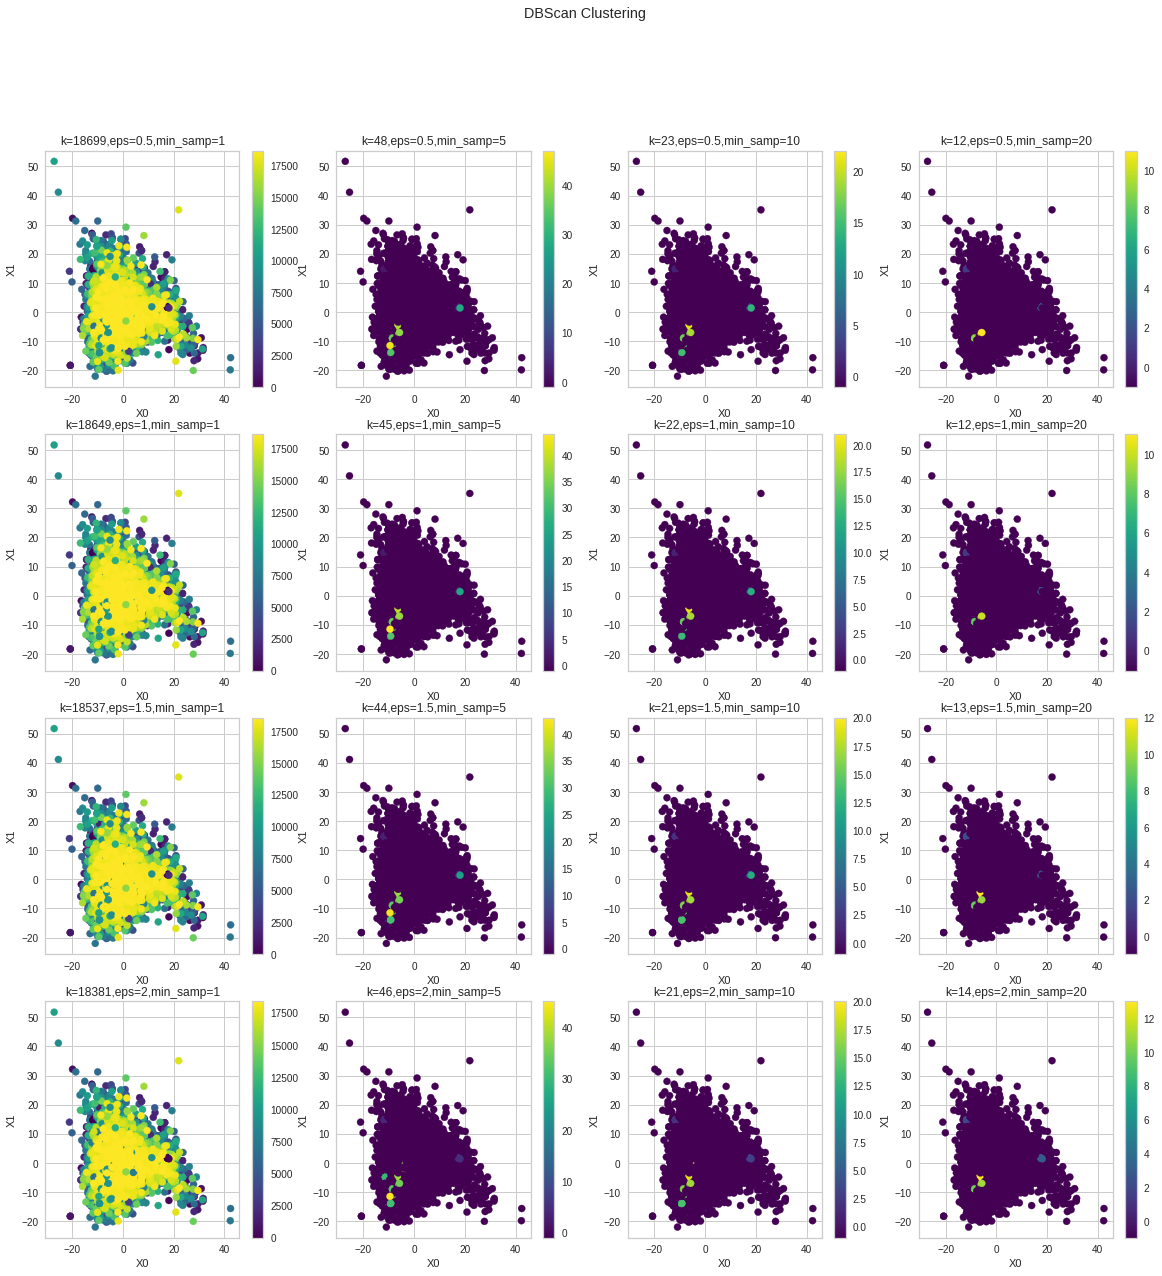

In [13]:
# Playing around with PCA to see if this makes a difference
pca_results,db_scan_pca_best_model = find_best_dbscan(X_pca, [.5, 1, 1.5, 2], [1,5,10,20])

In [14]:
pd.DataFrame(pca_results).sort_values('score', ascending=False)

,eps,min_samp,cluster,score,homogenity,completeness,davies_bouldin
12,2.0,1,18381,0.097791,0.961055,0.068850,0.084683
4,1.0,1,18649,0.091368,0.975426,0.069548,0.033206
8,1.5,1,18537,0.091299,0.970804,0.069401,0.056750
0,0.5,1,18699,0.089608,0.978120,0.069685,0.014288
7,1.0,20,12,-0.147809,0.022970,0.083753,0.872964
3,0.5,20,12,-0.149154,0.021691,0.082742,0.869136
15,2.0,20,14,-0.156296,0.030713,0.087631,0.941454
6,1.0,10,22,-0.158362,0.029885,0.083313,0.891851
2,0.5,10,23,-0.159920,0.028692,0.082280,0.892790
11,1.5,20,13,-0.160465,0.028495,0.088984,0.931081


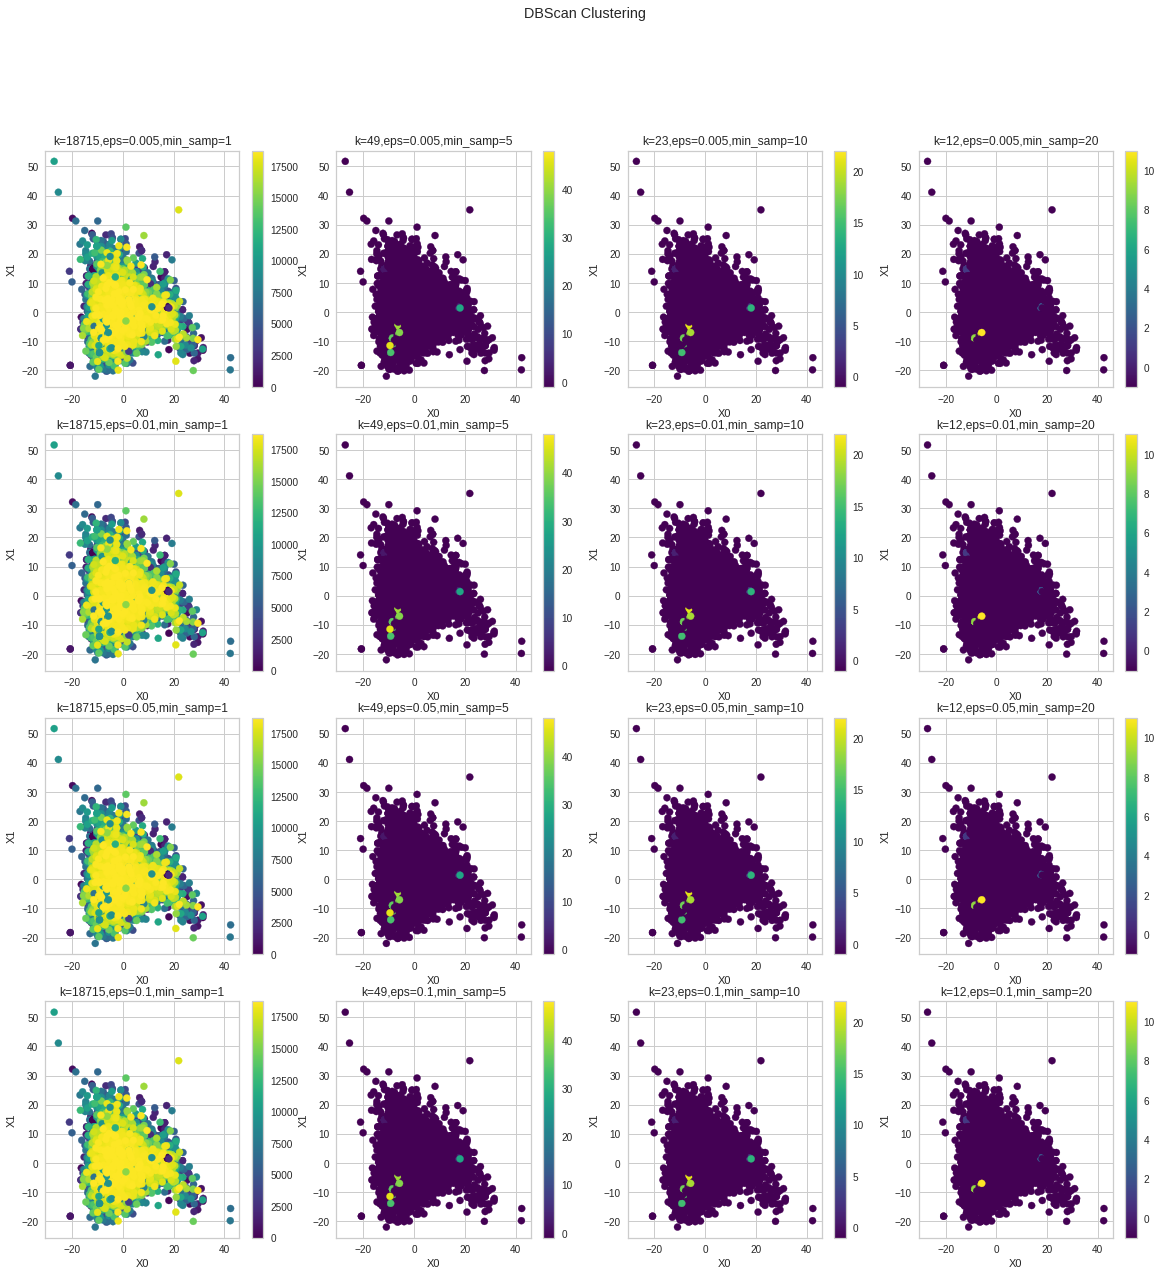

In [15]:
third_results, db_scan_thirdrun_best_model = find_best_dbscan(X_std, [.005,.01,.05,.1], [1,5,10,20])

In [16]:
third_results_df = pd.DataFrame(third_results)
lst_results.append(third_results_df)

In [17]:
full_results = pd.concat(lst_results)

In [18]:
full_results.sort_values('score', ascending=False)[:30]

,eps,min_samp,cluster,score,homogenity,completeness,davies_bouldin
0,0.005,1,18715,0.088800,0.978869,0.069724,6.971618e-07
12,0.100,1,18715,0.088800,0.978869,0.069724,6.971618e-07
8,0.050,1,18715,0.088800,0.978869,0.069724,6.971618e-07
4,0.010,1,18715,0.088800,0.978869,0.069724,6.971618e-07
5,1.000,20,12,-0.147809,0.022970,0.083753,8.729637e-01
1,0.500,20,12,-0.149154,0.021691,0.082742,8.691365e-01
11,0.050,20,12,-0.149154,0.021691,0.082742,8.691365e-01
7,0.010,20,12,-0.149154,0.021691,0.082742,8.691365e-01
3,0.005,20,12,-0.149154,0.021691,0.082742,8.691365e-01
15,0.100,20,12,-0.149154,0.021691,0.082742,8.691365e-01


In [ ]:
# The only positive values for silhouette score appear to very large clusters (over 18k)
# Even then, the scores are not very good to K-Means and even Agglomerative.

In [10]:
db_scan_best_model

DBSCAN(eps=2, min_samples=1, n_jobs=-1)

In [19]:
labels = DBSCAN(eps=1, min_samples=1, n_jobs=-1).fit_predict(X_std)

In [26]:
sns.set_style("whitegrid", {'axes.grid' : False})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


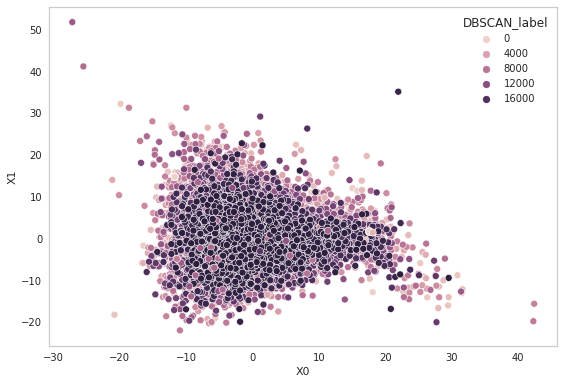

In [36]:
sample_df['DBSCAN_label'] = labels
plt.xlabel('X0')
plt.ylabel('X1')
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue=sample_df['DBSCAN_label'])
plt.tight_layout()
plt.savefig('drive/Shareddrives/Milestone 2/Clustering/dbscan.png',dpi=900)

In [25]:
sample_df['DBSCAN_label'].value_counts()

88       116
450       60
46        51
429       47
9420      45
        ... 
6380       1
6381       1
6382       1
6383       1
18648      1
Name: DBSCAN_label, Length: 18649, dtype: int64

In [30]:
#The largest cluster has 116 sentences.  Looking at the top 3 (by count) clusters to understand what where similar about the texts

sample_df[sample_df['DBSCAN_label'] ==88].sample(20)[['original_text']]

,original_text
ix,
243892,Exalead
341672,Massospondylus
83196,populationof = popofyear =
159004,Palearctic
311188,"Kagrra ,"
168669,MeshID = D015605
142702,Tyrimmas
190644,MedlinePlus = 001178
301952,Neotherapsida


In [ ]:
# These look like like they clustered around names.  The names don't seem to be
# of English origin and include names of places (Palearctic) and people (Tyrimmas) and also species (Massospondylus, Neotherapsida)

In [32]:
sample_df[sample_df['DBSCAN_label'] ==450].sample(20)[['original_text']]

,original_text
ix,
307902,It is found in the region Nord-Pas-de-Calais i...
232366,It is found in the region Nord-Pas-de-Calais i...
362077,It is found in the region Nord-Pas-de-Calais i...
211861,It is found in the region Picardie in the Aisn...
384724,It is found in the region Picardie in the Aisn...
310716,It is found in the region Nord-Pas-de-Calais i...
283056,It is found in the region Picardie in the Aisn...
367458,It is found in the region Nord-Pas-de-Calais i...
314874,It is found in the region Nord-Pas-de-Calais i...


In [ ]:
# Looks like clustering occurred around "It is found in the region..."

In [33]:
sample_df[sample_df['DBSCAN_label'] == 46].sample(20)[['original_text']]

,original_text
ix,
340074,References
410482,References
395207,References
375680,References
332632,References
382705,References
395112,References
317199,Reference
404069,References


In [ ]:
# One cluster around the word "Reference(s)"

In [34]:
sample_df[sample_df['DBSCAN_label'] == 429].sample(20)[['original_text']]

,original_text
ix,
358366,It is found in the region Basse-Normandie in t...
356456,It is found in the region Aquitaine in the Gir...
320280,It is found in the region Basse-Normandie in t...
277993,It is found in the region Basse-Normandie in t...
339662,It is found in the region Aquitaine in the Gir...
405839,It is found in the region Basse-Normandie in t...
385654,It is found in the region Basse-Normandie in t...
379794,It is found in the region Basse-Normandie in t...
242632,It is found in the region Basse-Normandie in t...


In [ ]:
# Another cluster based on regions in France